In [11]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [12]:
algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

In [19]:
# experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'monks2_attr3', 'biodeg_V29']
experiments = ['bank_housing', 'monks1_attr3', 'monks2_attr3', 'biodeg_V29']
# experiments = [dataset]

In [14]:
runs = {}
for exp in experiments:
    for alg in algorithms:
        runs[f'{exp}_{alg}'] = mlflow.search_runs(experiment_names=[f'{exp}_{alg}'], order_by=['start_time DESC'])
        # run_tag = run.loc[0, 'tags.run']
        # run = run.loc[run['tags.run'] == run_tag]
        # runs[f'{exp}_{alg}'] = run

In [15]:
metrics = [
    'accuracy',
    'roc_auc',
    'equal_opportunity_difference', 
    'predictive_equality_difference',
    'demographic_parity_difference',
    'equalized_odds_difference']

## Noise correction analysis

In [20]:
nr = [i/10 for i in range(1, 10)]
abbv = ['acc', 'fpr', 'fnr']
names = ['accuracy', 'false positive rate', 'false negative rate']

In [32]:
def show_correction_performance(noise_type):
    fig = plt.figure(figsize=(20, 4))
    axs = fig.subplots(1, 3)

    for i in range(3):
        for alg in algorithms:
            values = []
            for noise_rate in [f'{r}' for r in nr]:
                avg_value = []
                for exp in experiments:
                    run = runs[f'{exp}_{alg}']
                    avg_value.append(run.loc[(run['params.noise_type'] == noise_type) & (run['params.noise_rate'] == noise_rate)][f'metrics.correction_{abbv[i]}'].mean())
                values.append(np.mean(avg_value))

            axs[i].plot(nr, values, label=alg)
        axs[i].set_xlabel('Noise rate')
        axs[i].set_ylabel(f'Correction {names[i]}')
        axs[i].set_title(f'Correction {names[i]} comparison')
        axs[i].legend()

    plt.show()

### Noise type: instance-dependant label flipping

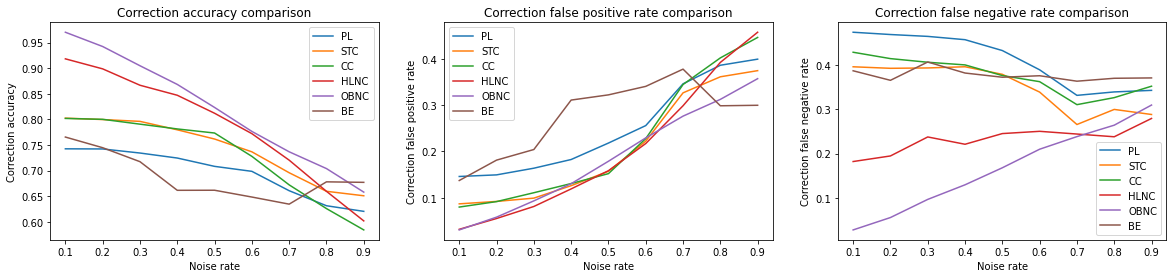

In [34]:
show_correction_performance('flip')

### Noise type: group bias

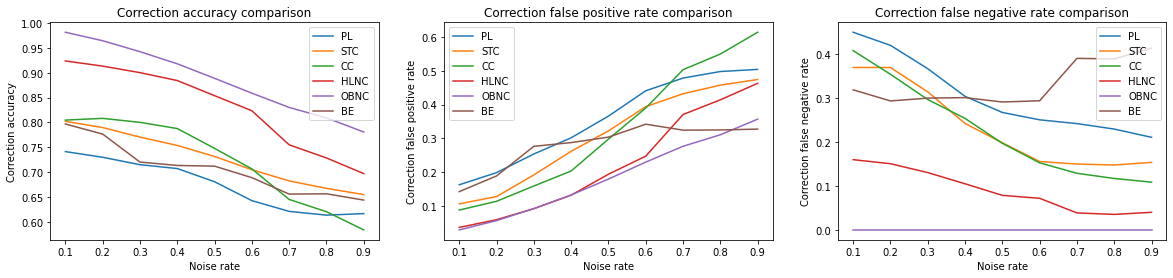

In [35]:
show_correction_performance('bias')

### Notes

- FNR para OBNC é sempre 0 -> "corrigir" tudo para positivo?

# Predictive performance comparison

In [36]:
def show_metric(exp, noise_type, test_set, metric, ax):
    run = runs[f'{exp}_PL']
    run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
    if test_set == 'original':
        ax.plot(nr, [run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'original')][f'metrics.{metric}'].values[0] for noise_rate in nr], label='original', color='black', linestyle='--', linewidth=2)
    ax.plot(nr, [run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0] for noise_rate in nr], label='noisy', color='r', linestyle='--',linewidth=2)

    for alg in algorithms:
        run = runs[f'{exp}_{alg}']
        run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
        ax.plot(nr, [run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0] for noise_rate in nr], label=alg)

    ax.set_title(f'{test_set} test set')
    ax.set_xlabel('Noise rate')
    ax.set_ylabel(f'{metric}')

In [37]:
def show_all_test_sets(exp, noise_type, metric):
    fig = plt.figure(figsize=(20, 4))
    axs = fig.subplots(1, 3, sharey=True)
    test_sets = ['original', 'noisy', 'corrected']

    for i in range(3):
        show_metric(exp, noise_type, test_sets[i], metric, axs[i])

    
    axs[2].legend(bbox_to_anchor=(1, 1))
    plt.suptitle(f'{exp} - {metric} comparison ({noise_type} noise)', fontsize=16, y=1.05)
    plt.show()

In [38]:
def show_metric_aggregated(noise_type, test_set, metric, ax):
    results = {alg: {noise_rate: [] for noise_rate in nr} for alg in algorithms}
    results['noisy'] = {noise_rate: [] for noise_rate in nr}
    if test_set == 'original':
        results['original'] = {noise_rate: [] for noise_rate in nr}

    for exp in experiments:
        run = runs[f'{exp}_PL']
        run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
        for noise_rate in nr:
            results['noisy'][noise_rate].append(run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0])
            if test_set == 'original':
                results['original'][noise_rate].append(run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'original')][f'metrics.{metric}'].values[0])
        for alg in algorithms:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
            for noise_rate in nr:
                results[alg][noise_rate].append(run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])

    if test_set == 'original':       
        ax.plot(nr, [np.mean(results['original'][noise_rate]) for noise_rate in nr], label='original', color='black', linestyle='--', linewidth=2)
    ax.plot(nr, [np.mean(results['noisy'][noise_rate]) for noise_rate in nr], label='noisy', color='r', linestyle='--',linewidth=2)

    for alg in algorithms:
        ax.plot(nr, [np.mean(results[alg][noise_rate]) for noise_rate in nr], label=alg)

    ax.set_title(f'{test_set} test set')
    ax.set_xlabel('Noise rate')
    ax.set_ylabel(f'{metric}')

In [78]:
def show_all_test_sets_aggr(noise_type, metric):
    fig = plt.figure(figsize=(18, 5))
    axs = fig.subplots(1, 2, sharey=True)
    test_sets = ['original', 'noisy']

    for i in range(2):
        show_metric_aggregated(noise_type, test_sets[i], metric, axs[i])

    
    axs[0].legend(bbox_to_anchor=(2.5, 1))
    plt.suptitle(f'{metric} comparison ({noise_type} noise)', fontsize=16, y=1.05)
    plt.show()

## Comparing on a single dataset

In [40]:
dataset = 'bank_housing'

### Flip noise (only evaluating predictive performance)

In [ ]:
#show_all_test_sets(dataset, 'flip', 'roc_auc')
#show_all_test_sets(dataset, 'flip', 'accuracy')

### Group bias noise

In [ ]:
#show_all_test_sets(dataset, 'bias', 'roc_auc')
#show_all_test_sets(dataset, 'bias', 'accuracy')

In [ ]:
# show_all_test_sets(dataset, 'bias', 'demographic_parity_difference')
# show_all_test_sets(dataset, 'bias', 'equal_opportunity_difference')
# show_all_test_sets(dataset, 'bias', 'equalized_odds_difference')
# show_all_test_sets(dataset, 'bias', 'predictive_equality_difference')

## Aggregated data

### Flip noise (only evaluating predictive performance)

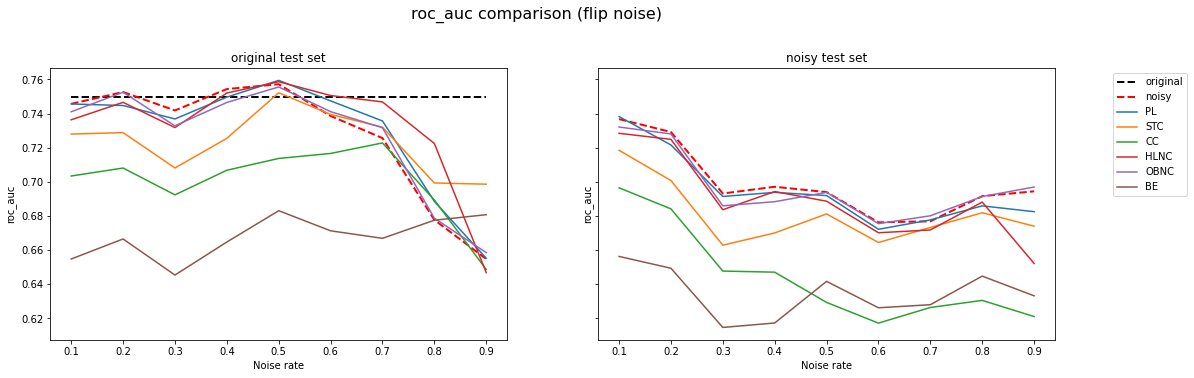

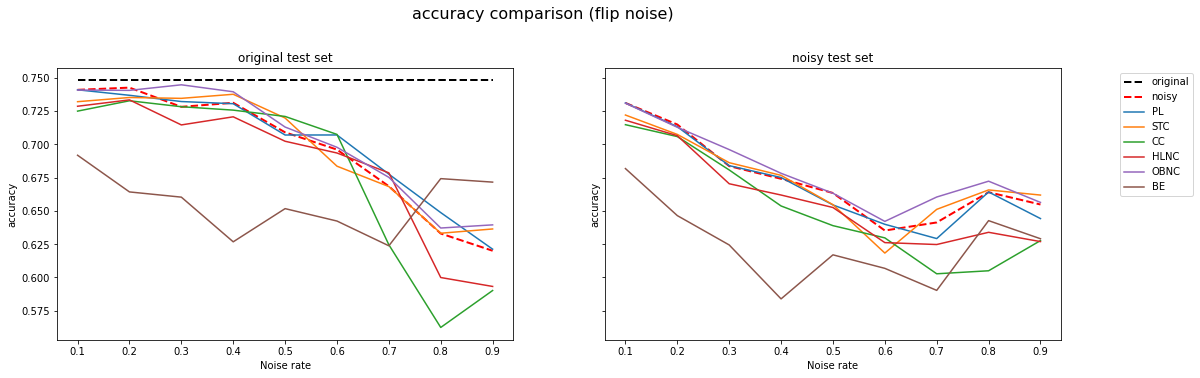

In [79]:
show_all_test_sets_aggr('flip', 'roc_auc')
show_all_test_sets_aggr('flip', 'accuracy')

### Group bias noise

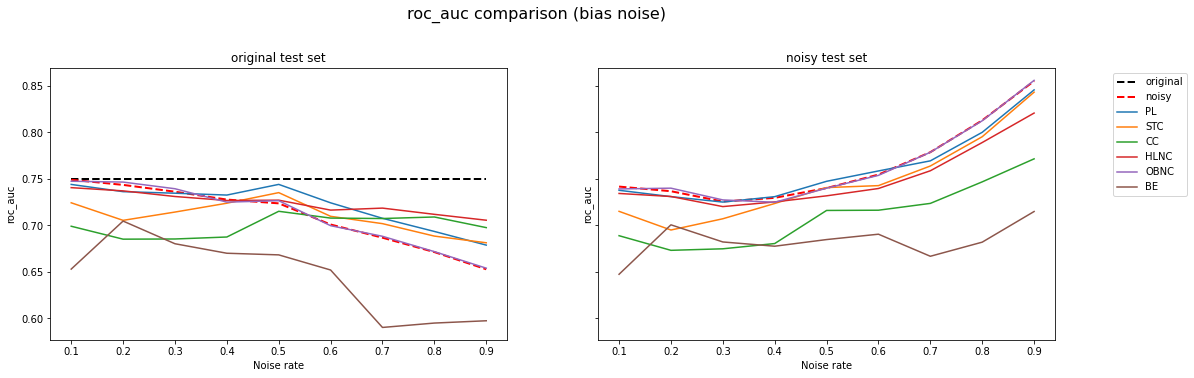

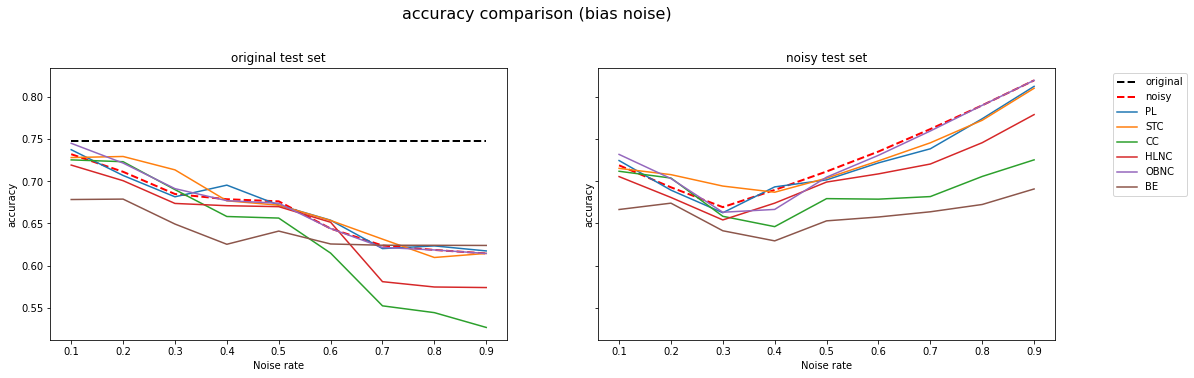

In [80]:
show_all_test_sets_aggr('bias', 'roc_auc')
show_all_test_sets_aggr('bias', 'accuracy')

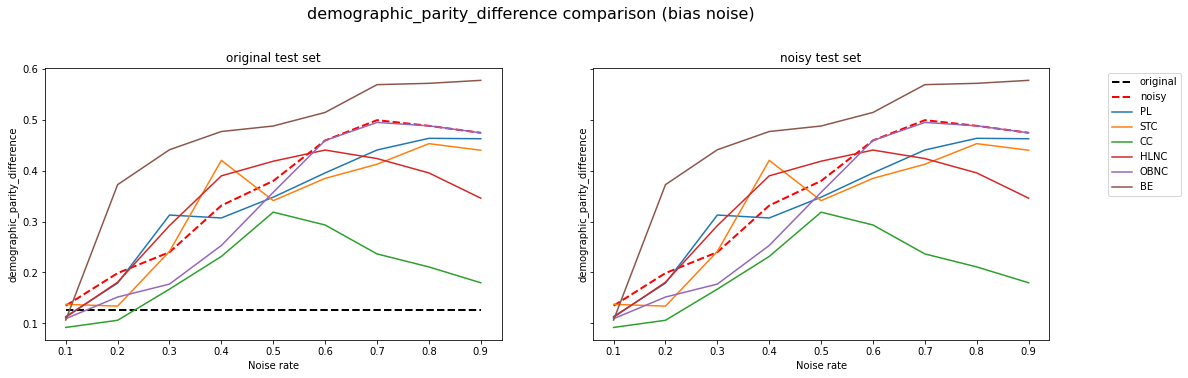

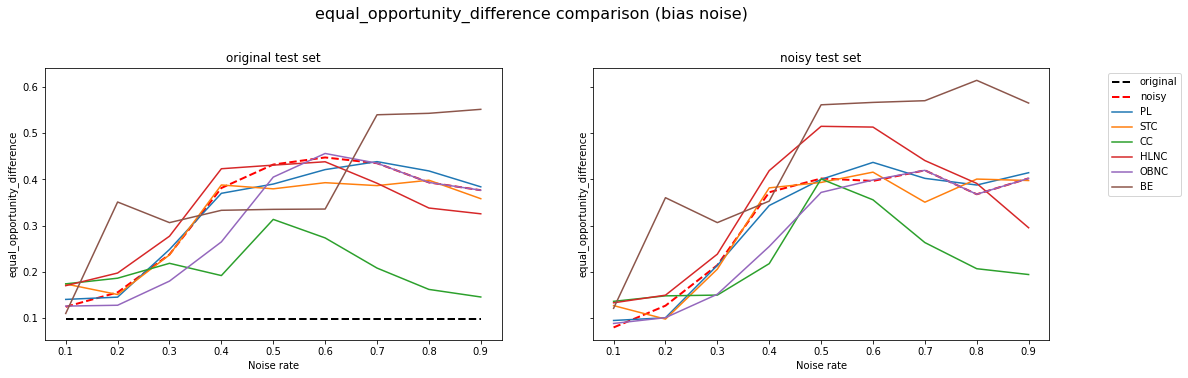

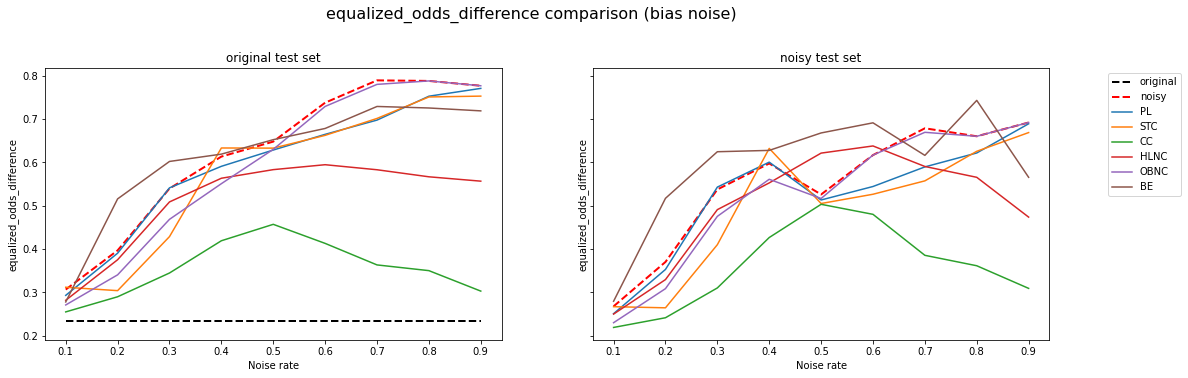

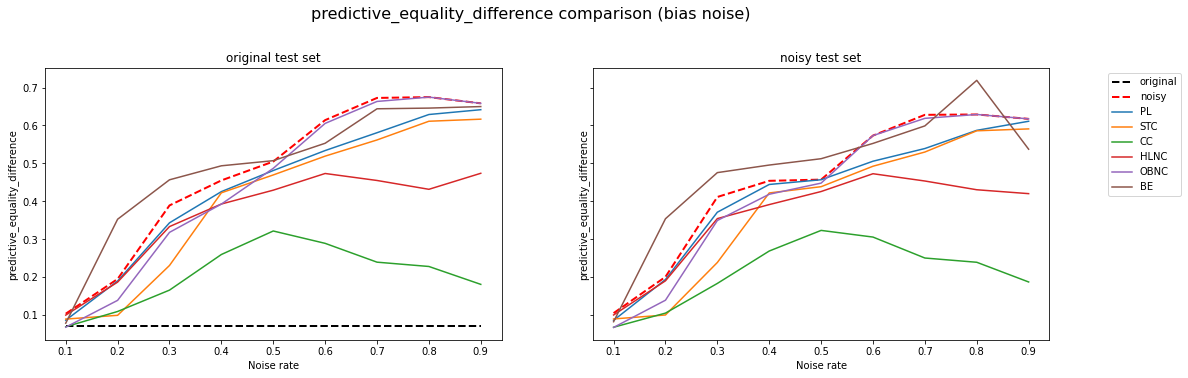

In [81]:
show_all_test_sets_aggr('bias', 'demographic_parity_difference')
show_all_test_sets_aggr('bias', 'equal_opportunity_difference')
show_all_test_sets_aggr('bias', 'equalized_odds_difference')
show_all_test_sets_aggr('bias', 'predictive_equality_difference')

## Accuracy/Fairness trade-offs

In [47]:
def show_trade_off(pred_metric, fair_metric, test_set, noise_rate, ax):
    if test_set == 'original':
        train_sets = ['original', 'noisy']
    else:
        train_sets = ['noisy']
    for train_set in train_sets:
        predictive_performance = []
        fairness = []
        for exp in experiments:
            run = runs[f'{exp}_PL']
            run = run.loc[(run['params.noise_type'] == 'bias') & (run['tags.test_set'] == test_set) & (run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == train_set)]
            predictive_performance.append(run[f'metrics.{pred_metric}'].values[0])
            fairness.append(run[f'metrics.{fair_metric}'].values[0])

        if train_set == 'original':
            c = 'black'
        else:
            c = 'r'
        
        ax.scatter(np.mean(fairness), np.mean(predictive_performance), label=train_set, color=c, marker='x', s=100)
        ax.axvline(x=np.mean(fairness), alpha=0.2, color=c, linestyle='--')
        ax.axhline(y=np.mean(predictive_performance), alpha=0.2, color=c, linestyle='--')
        

    for alg in algorithms:
        predictive_performance = []
        fairness = []
        for exp in experiments:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == 'bias') & (run['tags.test_set'] == test_set) & (run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')]
            predictive_performance.append(run[f'metrics.{pred_metric}'].values[0])
            fairness.append(run[f'metrics.{fair_metric}'].values[0])
        ax.scatter(np.mean(fairness), np.mean(predictive_performance), label=alg, s=40)

    ax.set_title(f'{test_set} test set')
    ax.set_xlabel(fair_metric)
    ax.set_ylabel(pred_metric)

In [85]:
def show_trade_off_all_test_sets(pred_metric, fair_metric, noise_rate):
    test_sets = ['original', 'noisy'] #, 'corrected']

    fig = plt.figure(figsize=(20, 5))
    axs = fig.subplots(1, 2, sharey=True, sharex=True)

    for i in range(2):
        show_trade_off(pred_metric, fair_metric, test_sets[i], noise_rate, axs[i])

    axs[0].legend(bbox_to_anchor=(2.4, 1))
    plt.suptitle(f'{pred_metric} vs {fair_metric} ({noise_rate} noise rate)', fontsize=16, y=1.05)
    plt.show()

In [49]:
noise_rate = '0.5'

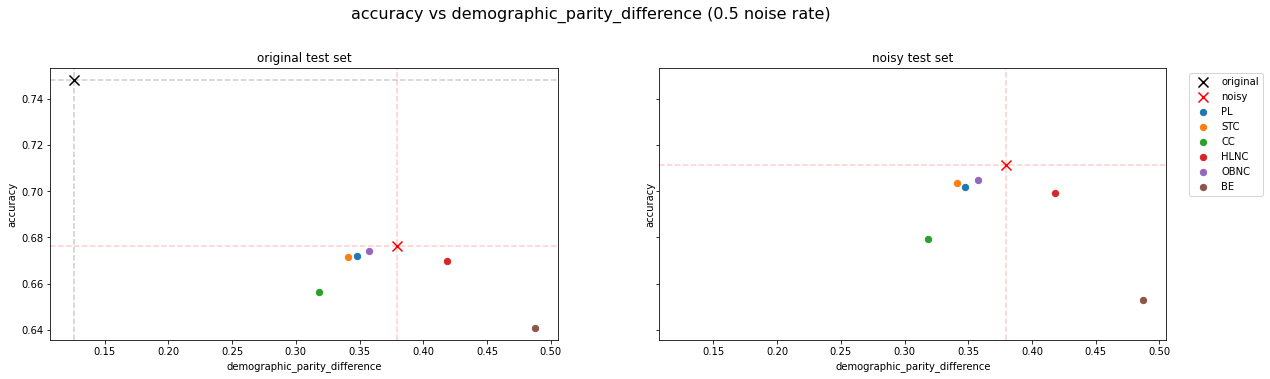

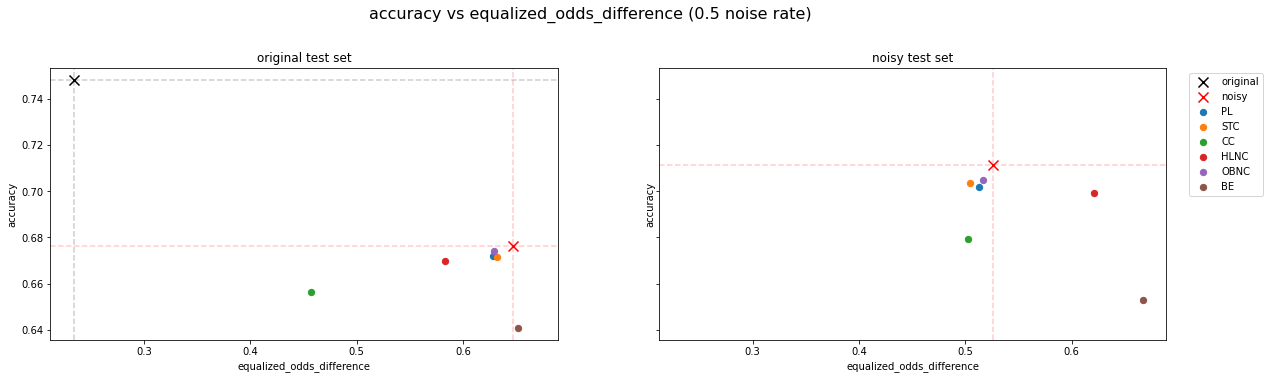

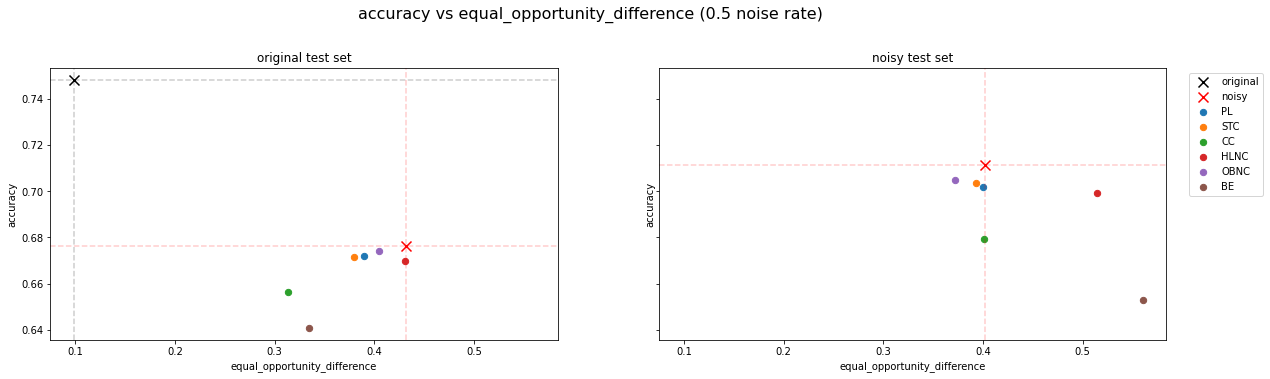

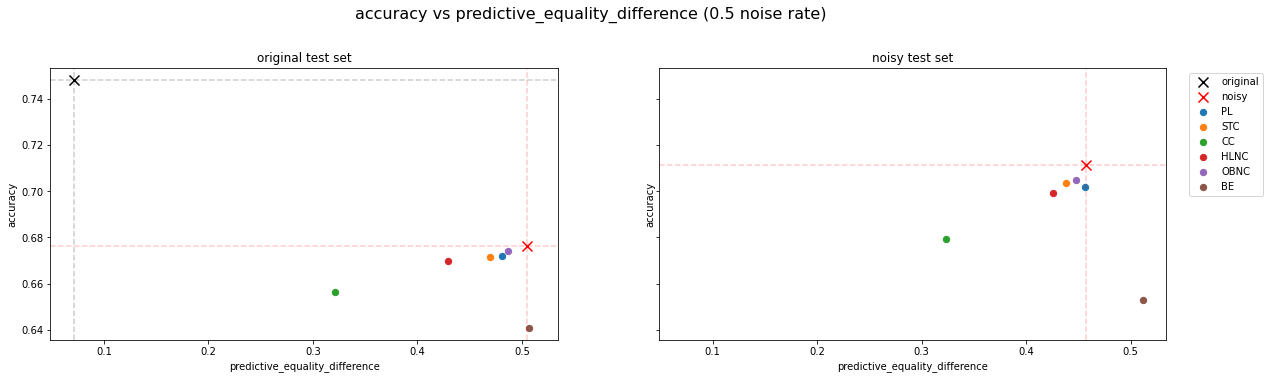

In [86]:
show_trade_off_all_test_sets('accuracy', 'demographic_parity_difference', noise_rate)
show_trade_off_all_test_sets('accuracy', 'equalized_odds_difference', noise_rate)
show_trade_off_all_test_sets('accuracy', 'equal_opportunity_difference', noise_rate)
show_trade_off_all_test_sets('accuracy', 'predictive_equality_difference', noise_rate)

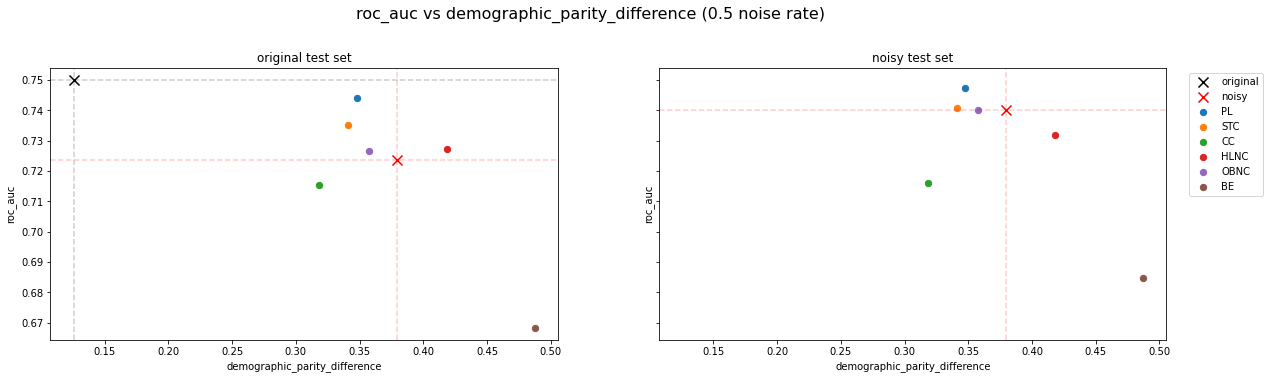

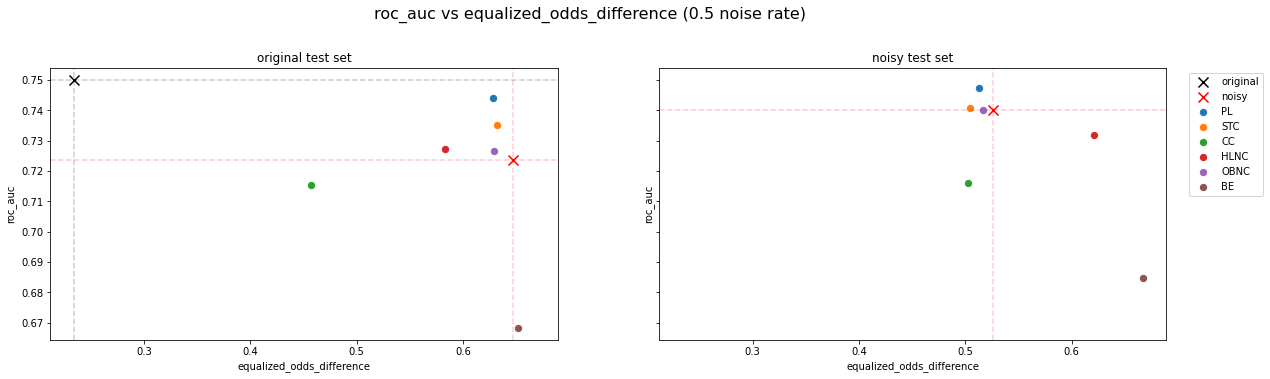

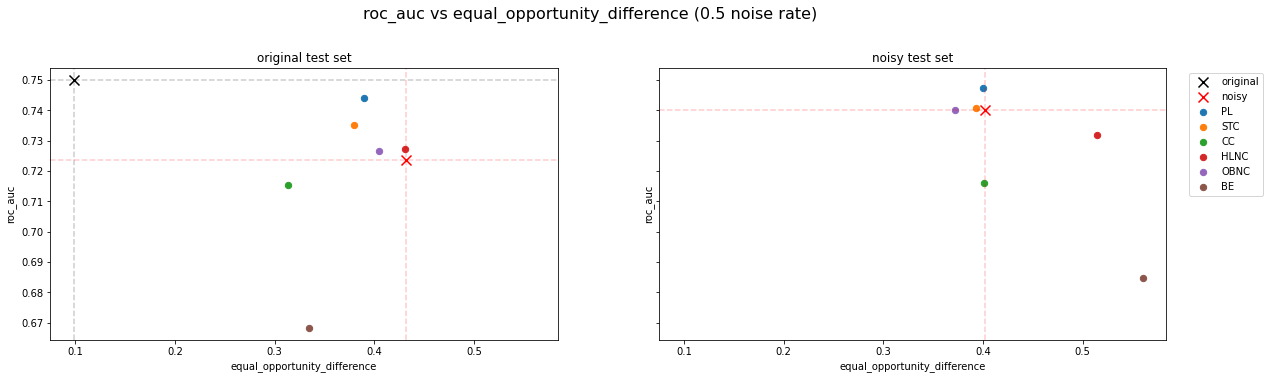

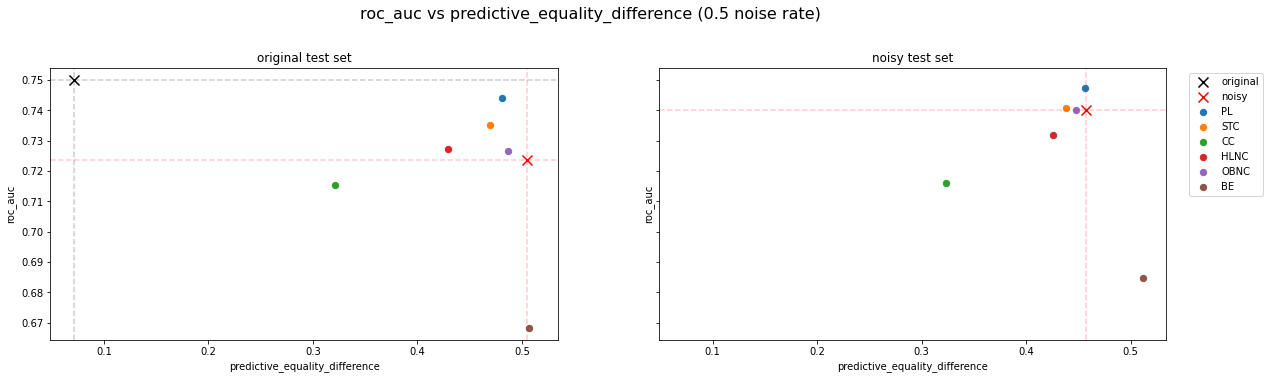

In [87]:
show_trade_off_all_test_sets('roc_auc', 'demographic_parity_difference', noise_rate)
show_trade_off_all_test_sets('roc_auc', 'equalized_odds_difference', noise_rate)
show_trade_off_all_test_sets('roc_auc', 'equal_opportunity_difference', noise_rate)
show_trade_off_all_test_sets('roc_auc', 'predictive_equality_difference', noise_rate)